In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D

In [41]:
df = pd.read_csv('/Users/minjeong/Downloads/train.csv')
df

,일자,종목코드,종목명,거래량,시가,고가,저가,종가
0,20210601,A060310,3S,166690,2890,2970,2885,2920
1,20210601,A095570,AJ네트웍스,63836,5860,5940,5750,5780
2,20210601,A006840,AK홀딩스,103691,35500,35600,34150,34400
3,20210601,A054620,APS,462544,14600,14950,13800,14950
4,20210601,A265520,AP시스템,131987,29150,29150,28800,29050
...,...,...,...,...,...,...,...,...
987995,20230530,A189980,흥국에프엔비,272284,3005,3035,2955,2980
987996,20230530,A000540,흥국화재,50218,3250,3255,3195,3215
987997,20230530,A003280,흥아해운,130664,1344,1395,1340,1370
987998,20230530,A037440,희림,141932,9170,9260,9170,9200


In [42]:
df.columns = ['Date', 'Code', 'Name', 'Volume', 'Open', 'High', 'Low','Close']

In [43]:
df = df[df['Code']=='A060310']
df

,Date,Code,Name,Volume,Open,High,Low,Close
0,20210601,A060310,3S,166690,2890,2970,2885,2920
2000,20210602,A060310,3S,134833,2915,2975,2830,2900
4000,20210603,A060310,3S,144470,2900,2925,2875,2900
6000,20210604,A060310,3S,934224,2930,3120,2920,2950
8000,20210607,A060310,3S,946560,3000,3150,2955,3150
...,...,...,...,...,...,...,...,...
978000,20230523,A060310,3S,117084,2300,2315,2260,2285
980000,20230524,A060310,3S,67101,2280,2300,2255,2280
982000,20230525,A060310,3S,91789,2260,2285,2235,2245
984000,20230526,A060310,3S,13590249,2245,2915,2230,2910


In [44]:
df = df [['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
df

,Date,Open,High,Low,Close,Volume
0,20210601,2890,2970,2885,2920,166690
2000,20210602,2915,2975,2830,2900,134833
4000,20210603,2900,2925,2875,2900,144470
6000,20210604,2930,3120,2920,2950,934224
8000,20210607,3000,3150,2955,3150,946560
...,...,...,...,...,...,...
978000,20230523,2300,2315,2260,2285,117084
980000,20230524,2280,2300,2255,2280,67101
982000,20230525,2260,2285,2235,2245,91789
984000,20230526,2245,2915,2230,2910,13590249


In [45]:
# Volume(거래량), Open(시가), High(고가), Low(저가), Close(종가)
df.shape

(494, 6)

In [46]:
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)

    return numerator / (denominator + 1e-7)

In [48]:
dfx = df[['Open','High','Low','Volume', 'Close']]
dfx = MinMaxScaler(dfx)
dfy = dfx[['Close']]
dfx = dfx[['Open','High','Low','Volume']]
dfx

,Open,High,Low,Volume
0,0.362534,0.347349,0.420705,0.001621
2000,0.372311,0.349177,0.396476,0.001207
4000,0.366445,0.330896,0.416300,0.001332
6000,0.378178,0.402194,0.436123,0.011601
8000,0.405553,0.413163,0.451542,0.011761
...,...,...,...,...
978000,0.131795,0.107861,0.145374,0.000976
980000,0.123973,0.102377,0.143172,0.000326
982000,0.116152,0.096892,0.134361,0.000647
984000,0.110285,0.327239,0.132159,0.176155


In [49]:
dfx.describe()

,Open,High,Low,Volume
count,494.000000,494.000000,494.000000,494.000000
mean,0.388270,0.371748,0.428200,0.011022
std,0.223416,0.216861,0.243649,0.053506
min,0.000000,0.000000,0.000000,0.000000
25%,0.158193,0.154022,0.174559,0.001332
50%,0.390888,0.384826,0.431718,0.002464
75%,0.534611,0.504113,0.583700,0.005128
max,1.000000,1.000000,1.000000,1.000000


In [50]:
# 두 데이터를 리스트 형태로 저장
X = dfx.values.tolist()
y = dfy.values.tolist()

In [59]:
window_size = 10

data_X = []
data_y = []
for i in range(len(y) - window_size):
    _X = X[i : i + window_size] # 다음 날 종가(i+windows_size)는 포함되지 않음
    _y = y[i + window_size]     # 다음 날 종가
    data_X.append(_X)
    data_y.append(_y)
print(_X, "->", _y)

[[0.12006257332342345, 0.09506398537129565, 0.12995594713083897, 0.0003577772826598893], [0.10833007430159054, 0.0840950639823, 0.11233480175716587, 0.0009727870310734309], [0.09855299178339645, 0.08775137111196522, 0.11894273127229328, 0.0007246039889027013], [0.11028549080522936, 0.09872029250096087, 0.13656387664596636, 0.0011905842931963296], [0.13179507234525636, 0.10603290676029131, 0.1519823788479303, 0.0026100045850412784], [0.12983965584161755, 0.11517367458445435, 0.14096916298938464, 0.0014869269114462914], [0.13179507234525636, 0.10786106032512392, 0.14537444933280289, 0.0009760245403724937], [0.12397340633070109, 0.10237659963062609, 0.14317180616109376, 0.0003261433062557933], [0.11615174031614581, 0.09689213893612826, 0.1343612334742572, 0.0006471378025419926], [0.11028549080522936, 0.32723948810503695, 0.1321585903025481, 0.1761547272524533]] -> [0.39539347407311354]


In [60]:
print('전체 데이터의 크기 :', len(data_X), len(data_y))

전체 데이터의 크기 : 484 484


In [62]:
train_size = int(len(data_y) * 0.7)
train_X = np.array(data_X[0 : train_size])
train_y = np.array(data_y[0 : train_size])

test_size = len(data_y) - train_size
test_X = np.array(data_X[train_size : len(data_X)])
test_y = np.array(data_y[train_size : len(data_y)])

print('훈련 데이터의 크기 :', train_X.shape, train_y.shape)
print('테스트 데이터의 크기 :', test_X.shape, test_y.shape)

훈련 데이터의 크기 : (338, 10, 4) (338, 1)
테스트 데이터의 크기 : (146, 10, 4) (146, 1)


In [63]:
model = Sequential()
model.add(LSTM(units=20, activation='relu', return_sequences=True, input_shape=(10, 4)))
model.add(Dropout(0.1))
model.add(LSTM(units=20, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10, 20)            2000      
                                                                 
 dropout_4 (Dropout)         (None, 10, 20)            0         
                                                                 
 lstm_5 (LSTM)               (None, 20)                3280      
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 5301 (20.71 KB)
Trainable params: 5301 (20.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [64]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(train_X, train_y, epochs=70, batch_size=30)
pred_y = model.predict(test_X)

Epoch 1/70
12/12 [==============================] - 1s 3ms/step - loss: 0.2368
Epoch 2/70
12/12 [==============================] - 0s 2ms/step - loss: 0.1697
Epoch 3/70
12/12 [==============================] - 0s 2ms/step - loss: 0.0594
Epoch 4/70
12/12 [==============================] - 0s 2ms/step - loss: 0.0211
Epoch 5/70
12/12 [==============================] - 0s 2ms/step - loss: 0.0165
Epoch 6/70
12/12 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 7/70
12/12 [==============================] - 0s 2ms/step - loss: 0.0155
Epoch 8/70
12/12 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 9/70
12/12 [==============================] - 0s 3ms/step - loss: 0.0145
Epoch 10/70
12/12 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 11/70
12/12 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 12/70
12/12 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 13/70
12/12 [==============================

In [65]:
model.evaluate(test_X, test_y)

5/5 [==============================] - 0s 1ms/step - loss: 0.0033


0.0033369753509759903

5/5 [==============================] - 0s 2ms/step


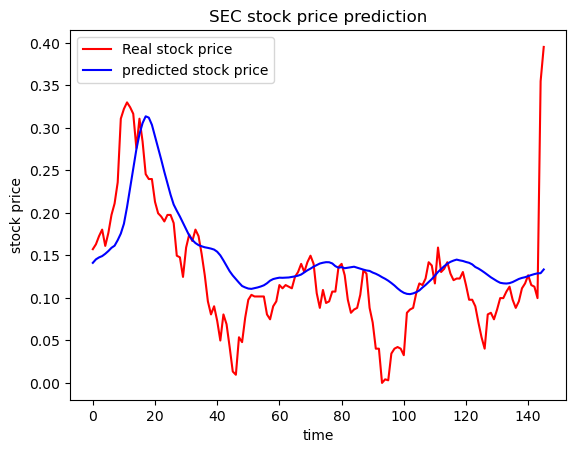

In [68]:
pred_y = model.predict(test_X)

plt.figure()
plt.plot(test_y, color='red', label='Real stock price')
plt.plot(pred_y, color='blue', label='predicted stock price')
plt.title('SEC stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()